In [53]:
import pymongo
from pymongo import MongoClient
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix
import math

In [54]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["HeartDiseasePrediction"]
collections= db["heart_2022"]
cursor = collections.find().limit(15000)
json_data = list(cursor)

df = pd.DataFrame(json_data)


In [55]:
print(df.head())

                        _id    State     Sex GeneralHealth  \
0  657f60660e990468ed8a28df  Alabama  Female     Very good   
1  657f60660e990468ed8a28e0  Alabama  Female     Excellent   
2  657f60660e990468ed8a28e1  Alabama  Female     Very good   
3  657f60660e990468ed8a28e2  Alabama  Female     Excellent   
4  657f60660e990468ed8a28e3  Alabama  Female          Fair   

   PhysicalHealthDays  MentalHealthDays  \
0                 0.0               0.0   
1                 0.0               0.0   
2                 2.0               3.0   
3                 0.0               0.0   
4                 2.0               0.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                 No   
1                                                NaN                 No   
2  Within past year (anytime less than 12 months ...                Yes   
3  Within past year (anytime less than 12 months ...                

In [56]:
print(df.tail())

                            _id    State     Sex GeneralHealth  \
14995  657f60670e990468ed8a6372  Arizona    Male     Very good   
14996  657f60670e990468ed8a6373  Arizona    Male     Very good   
14997  657f60670e990468ed8a6374  Arizona    Male     Very good   
14998  657f60670e990468ed8a6375  Arizona    Male     Excellent   
14999  657f60670e990468ed8a6376  Arizona  Female          Fair   

       PhysicalHealthDays  MentalHealthDays  \
14995                 2.0               0.0   
14996                 0.0               5.0   
14997                 0.0               0.0   
14998                 0.0               0.0   
14999                 NaN               NaN   

                                         LastCheckupTime PhysicalActivities  \
14995  Within past year (anytime less than 12 months ...                Yes   
14996  Within past year (anytime less than 12 months ...                Yes   
14997  Within past year (anytime less than 12 months ...                Yes   
1499

In [57]:
df.shape

(15000, 41)

In [58]:
df.columns

Index(['_id', 'State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma',
       'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
       'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing',
       'BlindOrVisionDifficulty', 'DifficultyConcentrating',
       'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
       'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12',
       'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'RemovedTeeth'],
      dtype='object')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _id                        15000 non-null  object 
 1   State                      15000 non-null  object 
 2   Sex                        15000 non-null  object 
 3   GeneralHealth              14948 non-null  object 
 4   PhysicalHealthDays         14575 non-null  float64
 5   MentalHealthDays           14650 non-null  float64
 6   LastCheckupTime            14668 non-null  object 
 7   PhysicalActivities         14956 non-null  object 
 8   SleepHours                 14800 non-null  float64
 9   HadHeartAttack             14864 non-null  object 
 10  HadAngina                  14824 non-null  object 
 11  HadStroke                  14940 non-null  object 
 12  HadAsthma                  14931 non-null  object 
 13  HadSkinCancer              14891 non-null  obj

In [60]:
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,14575.000000,14650.000000,14800.000000,14251.000000,13853.000000,13649.000000
mean,4.883431,4.422662,7.070473,1.703062,83.294083,28.587377
std,9.221810,8.553019,1.581737,0.105972,21.354268,6.497582
min,0.000000,0.000000,1.000000,0.910000,24.000000,12.940000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.210000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,5.000000,4.000000,8.000000,1.780000,95.250000,31.870000
max,30.000000,30.000000,24.000000,2.260000,281.000000,91.720000


In [61]:
df.isna().sum().sort_values(ascending = False).head()

TetanusLast10Tdap    2670
PneumoVaxEver        2384
HIVTesting           2182
ChestScan            1814
RemovedTeeth         1648
dtype: int64

In [62]:
df.drop(columns = ['State', 'Sex'], inplace = True)
df.dropna(inplace= True)
df.head(5)

,_id,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,HadHeartAttack,HadAngina,HadStroke,...,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HeightInMeters,WeightInKilograms,BMI,RemovedTeeth
342,657f60660e990468ed8a2a35,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,No,No,No,...,No,Yes,Yes,"Yes, received Tdap",No,No,1.60,71.67,27.99,None of them
343,657f60660e990468ed8a2a36,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,No,No,No,...,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,1.78,95.25,30.13,None of them
345,657f60660e990468ed8a2a38,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,No,No,No,...,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,1.85,108.86,31.66,"6 or more, but not all"
346,657f60660e990468ed8a2a39,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,No,No,No,...,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,1.70,90.72,31.32,None of them
347,657f60660e990468ed8a2a3a,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,No,No,No,...,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,1.55,79.38,33.07,1 to 5


In [63]:
replacement_dict = {'Yes': 1, 'No': 0}
df['HadHeartAttack'] = df['HadHeartAttack'].replace(replacement_dict)
df['HadAngina'] = df['HadAngina'].replace(replacement_dict)

In [64]:
df.head(5)

,_id,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,HadHeartAttack,HadAngina,HadStroke,...,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HeightInMeters,WeightInKilograms,BMI,RemovedTeeth
342,657f60660e990468ed8a2a35,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,0,0,No,...,No,Yes,Yes,"Yes, received Tdap",No,No,1.60,71.67,27.99,None of them
343,657f60660e990468ed8a2a36,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,0,0,No,...,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,1.78,95.25,30.13,None of them
345,657f60660e990468ed8a2a38,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,0,0,No,...,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,1.85,108.86,31.66,"6 or more, but not all"
346,657f60660e990468ed8a2a39,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,0,0,No,...,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,1.70,90.72,31.32,None of them
347,657f60660e990468ed8a2a3a,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,0,0,No,...,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,1.55,79.38,33.07,1 to 5


In [65]:
# Check for missing values
print(df['HadHeartAttack'].isnull().any())
print(df['HadAngina'].isnull().any())

False
False


In [66]:
# Handle missing values (fill with 0 or any other appropriate value)
df['HadHeartAttack'].fillna(0, inplace=True)
df['HadAngina'].fillna(0, inplace=True)

In [67]:
# Check for non-numeric values
print(df['HadHeartAttack'].apply(lambda x: not isinstance(x, (int, float))).any())
print(df['HadAngina'].apply(lambda x: not isinstance(x, (int, float))).any())

# Convert non-numeric values to numeric (assuming they are convertible)
df['HadHeartAttack'] = pd.to_numeric(df['HadHeartAttack'], errors='coerce')
df['HadAngina'] = pd.to_numeric(df['HadAngina'], errors='coerce')


False
False


In [68]:
df['HadHeartAttack'] = df['HadHeartAttack'].astype(int)
df['HadAngina'] = df['HadAngina'].astype(int)


In [69]:
df['HeartDisease'] = df['HadHeartAttack'] | df['HadAngina']

In [70]:
df.drop(columns = ['HadHeartAttack','HadAngina'], inplace = True)

In [71]:
df.shape

(7605, 38)

In [72]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
print(df_num.shape)
df_num.head(5)

(7605, 7)


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,HeartDisease
342,4.0,0.0,9.0,1.60,71.67,27.99,0
343,0.0,0.0,6.0,1.78,95.25,30.13,0
345,0.0,0.0,8.0,1.85,108.86,31.66,0
346,5.0,0.0,9.0,1.70,90.72,31.32,0
347,3.0,15.0,5.0,1.55,79.38,33.07,0


<Figure size 1600x2000 with 0 Axes>

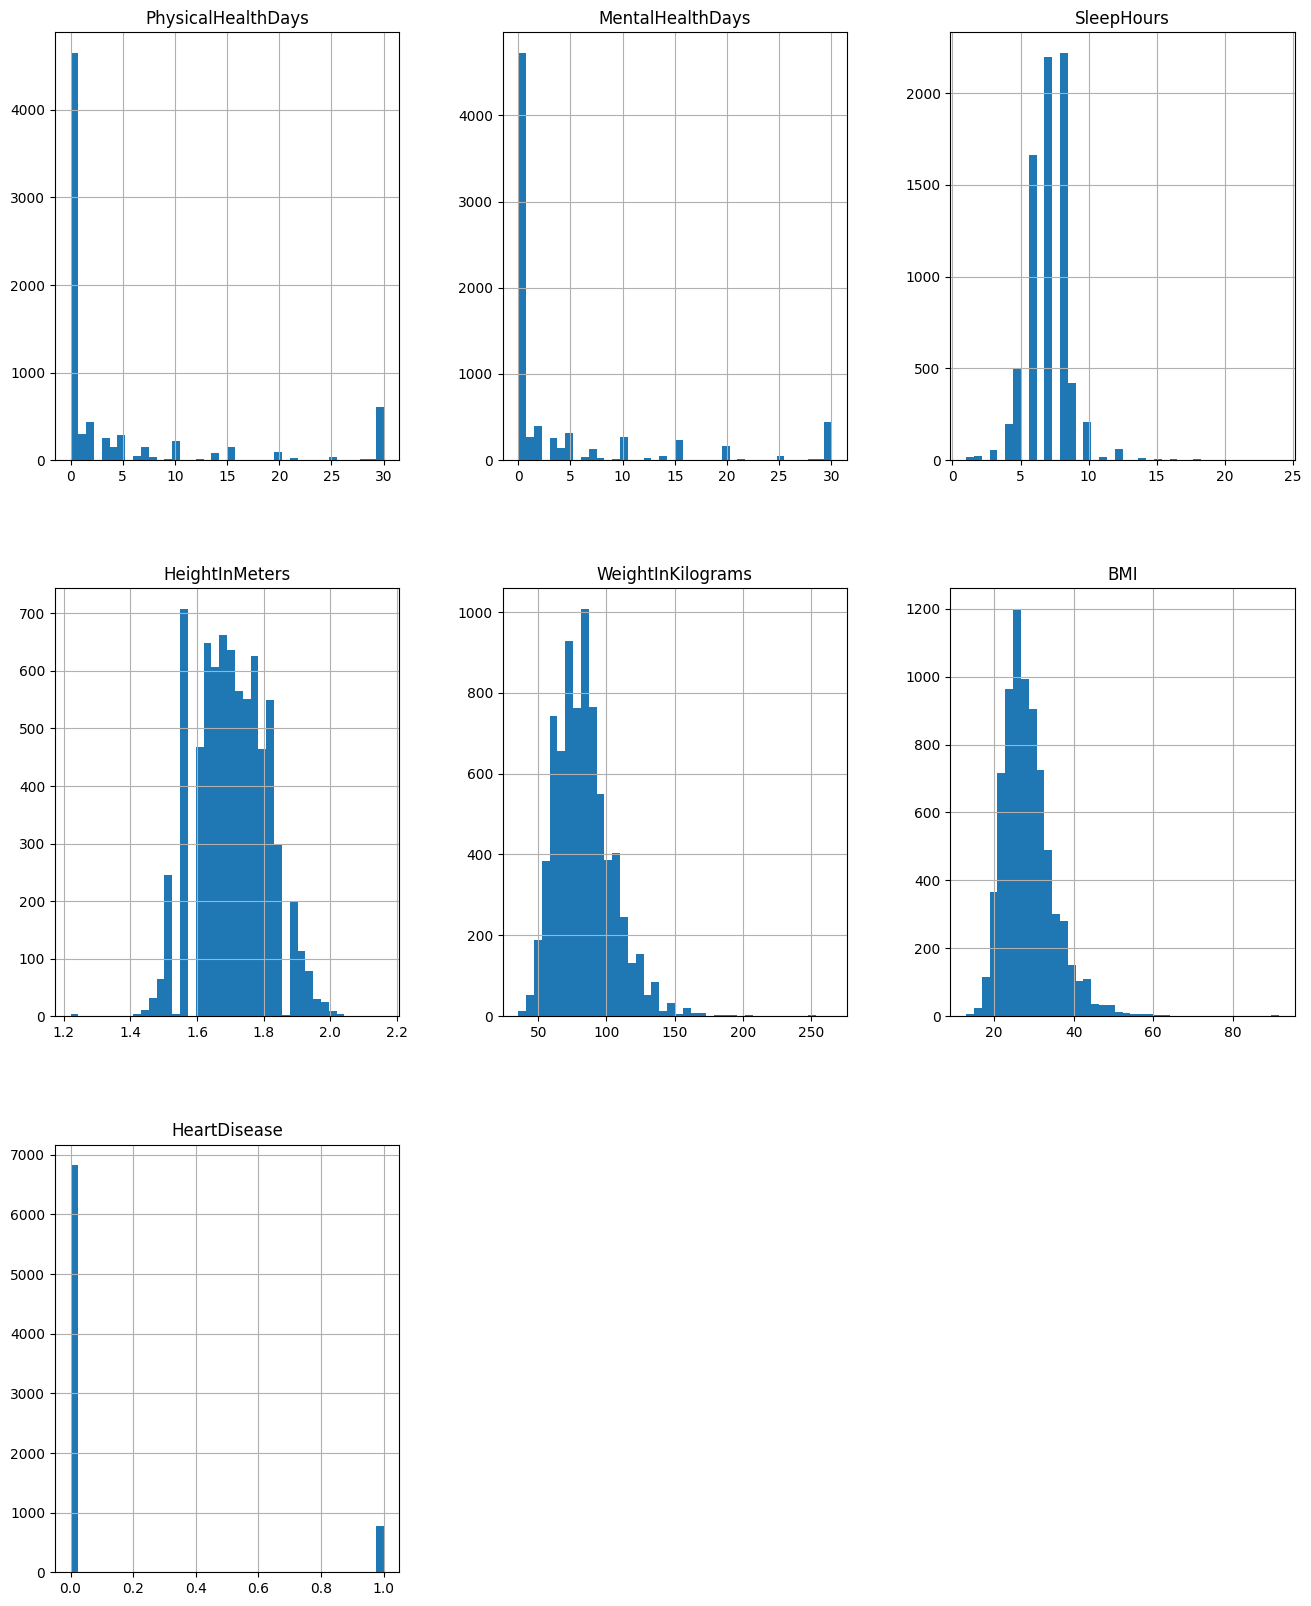

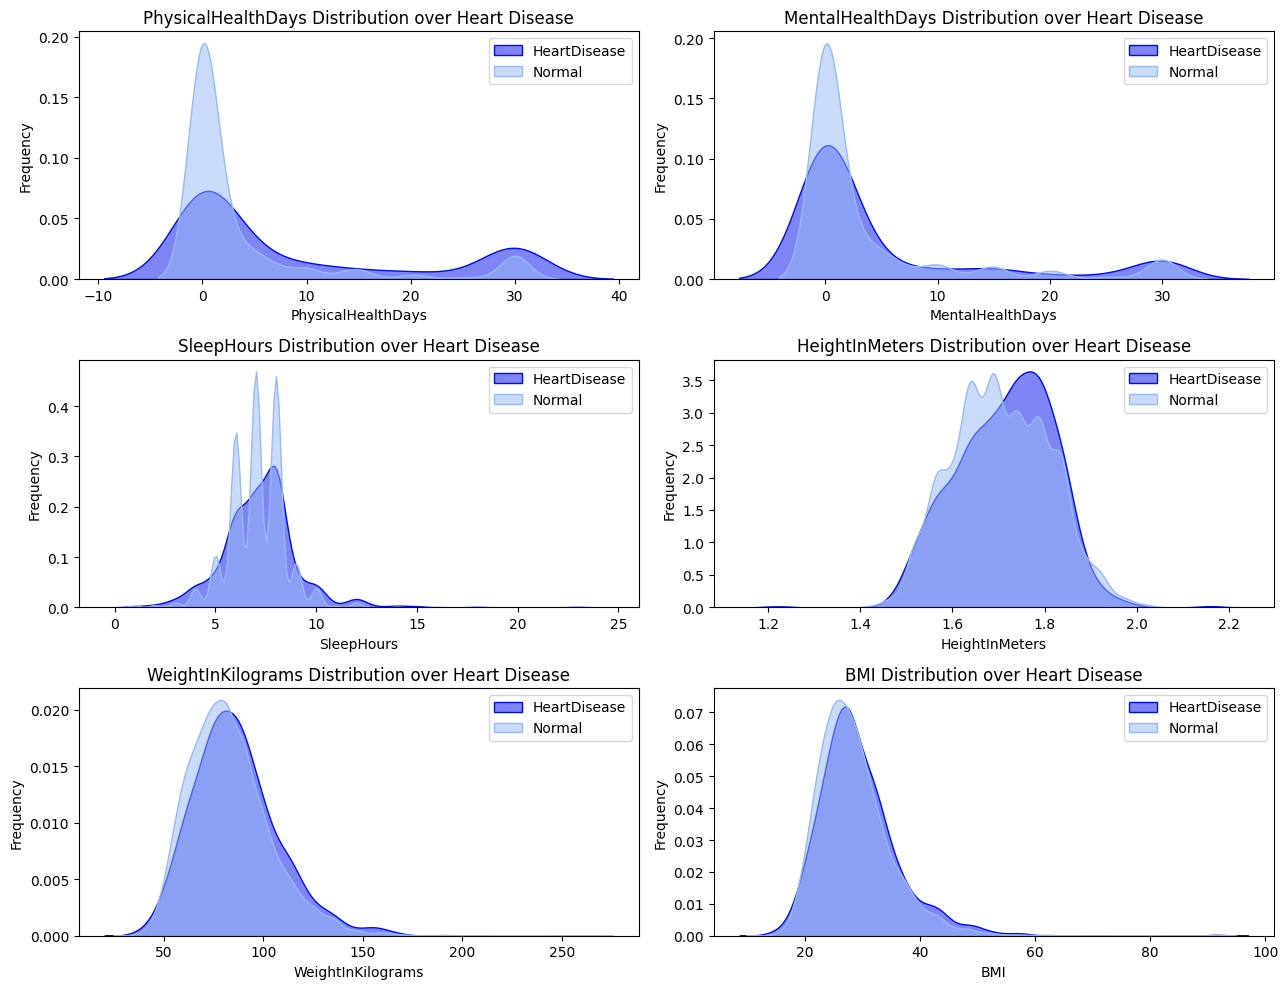

In [73]:
#Plot the distribution for all the numerical features
plt.figure(figsize=(16, 20))
df_num.hist(figsize=(16, 20), bins=40, xlabelsize=10, ylabelsize=10);
# plt.savefig('numerical_features_distribution.png')  # Save the overall distribution plot
# plt.close()

fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(13, 10))

for idx, column in enumerate(df_num.drop(columns = 'HeartDisease')):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.kdeplot(df[df["HeartDisease"] == 1][column], alpha=0.5, fill=True, color="#000CEB", label="HeartDisease", ax=axes[row_idx, col_idx])
    sns.kdeplot(df[df["HeartDisease"] == 0][column], alpha=0.5, fill=True, color="#97B9F4", label="Normal", ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_xlabel(column)
    axes[row_idx, col_idx].set_ylabel("Frequency")
    axes[row_idx, col_idx].set_title(f"{column} Distribution over Heart Disease")
    axes[row_idx, col_idx].legend()

plt.tight_layout()
plt.savefig('individual_feature_distributions.png')
plt.show()

In [74]:
df_cat = df.select_dtypes('object')
df_cat.nunique().sort_values()

DifficultyWalking               2
HIVTesting                      2
FluVaxLast12                    2
DifficultyErrands               2
DifficultyDressingBathing       2
DifficultyConcentrating         2
BlindOrVisionDifficulty         2
DeafOrHardOfHearing             2
PneumoVaxEver                   2
ChestScan                       2
HadArthritis                    2
HadDepressiveDisorder           2
HadCOPD                         2
HadSkinCancer                   2
HadAsthma                       2
HadStroke                       2
PhysicalActivities              2
HighRiskLastYear                2
HadKidneyDisease                2
AlcoholDrinkers                 2
CovidPos                        3
TetanusLast10Tdap               4
RemovedTeeth                    4
ECigaretteUsage                 4
SmokerStatus                    4
HadDiabetes                     4
LastCheckupTime                 4
RaceEthnicityCategory           5
GeneralHealth                   5
AgeCategory   

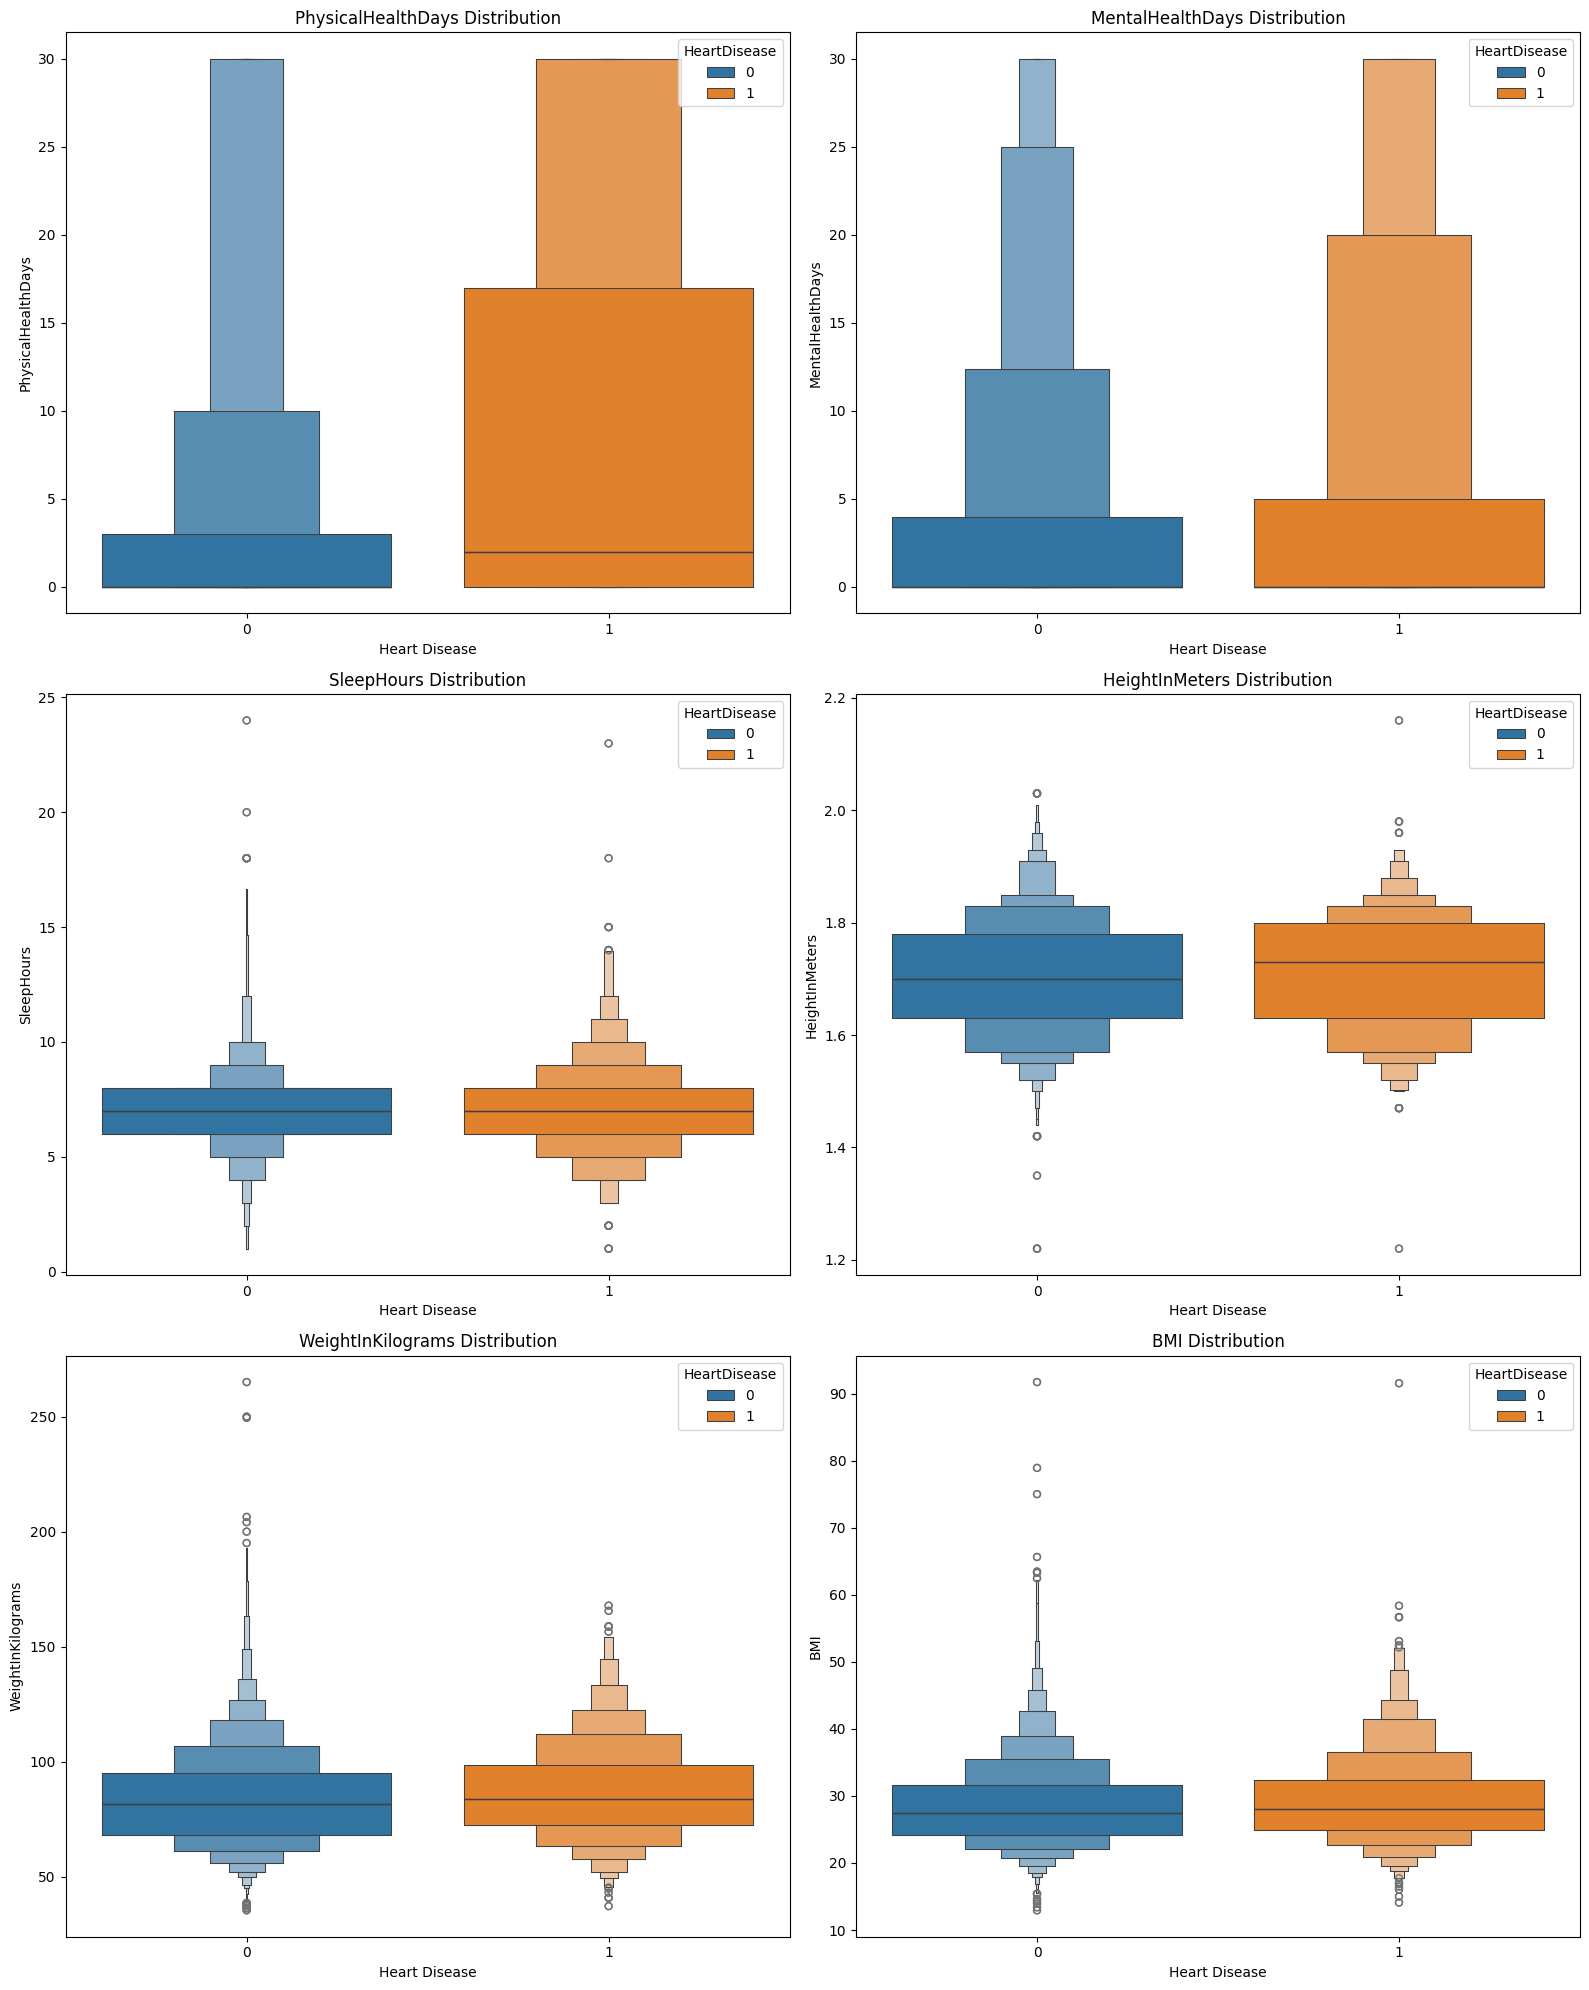

In [75]:
fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(16, 20))

for idx, column in enumerate(df_num.drop(columns = 'HeartDisease')):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.boxenplot( x='HeartDisease' , y= column , data=df, ax=axes[row_idx, col_idx])
    sns.boxenplot(x='HeartDisease', y=column, data=df, hue='HeartDisease', ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_xlabel("Heart Disease")
    axes[row_idx, col_idx].set_ylabel(column)
    axes[row_idx, col_idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.savefig('Box Ploting of Numerical Feature.png')
plt.show()


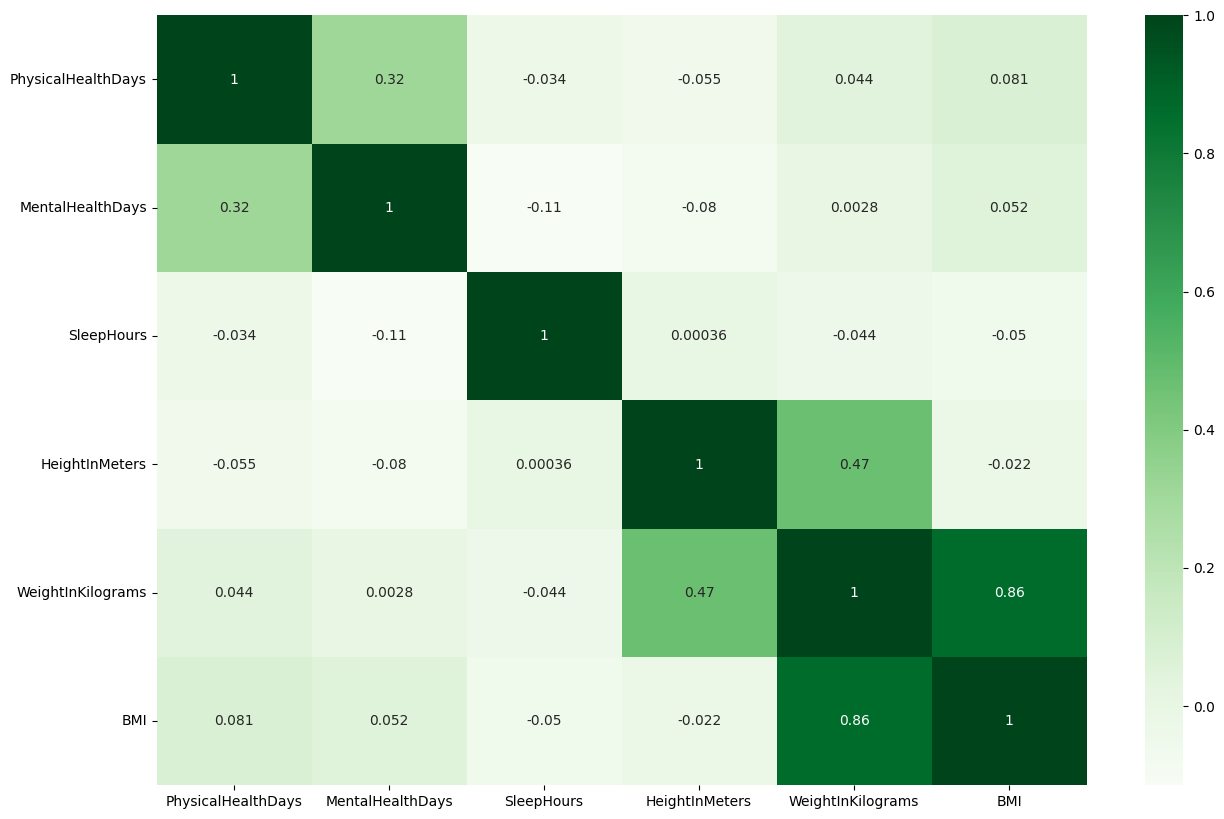

In [76]:
corr = df_num.drop(columns= 'HeartDisease').corr()
fig , ax = plt.subplots(figsize=(15 , 10))
sns.heatmap(corr ,annot= True , ax=ax , cmap= 'Greens');

In [77]:
# To check the correlation for columns => WeightInKilograms & BMI with the target
print(f"Correlation between WeightInKilograms and BMI :{df['WeightInKilograms'].corr(df['BMI'])}")

print(f"Correlation between WeightInKilograms and the target :{df['WeightInKilograms'].corr(df['HeartDisease'])}")

print(f"Correlation between BMI and the target :{df['BMI'].corr(df['HeartDisease'])}")
# drop 'WeightInKilograms' column
df.drop(columns = 'WeightInKilograms', inplace = True)

Correlation between WeightInKilograms and BMI :0.8626343259764484
Correlation between WeightInKilograms and the target :0.04558586926082496
Correlation between BMI and the target :0.039802510507424664


In [78]:
dfc = df
df_categorical=df_cat.columns
df_categorical


Index(['_id', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos', 'RemovedTeeth'],
      dtype='object')

In [79]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), list(df_categorical))],
    remainder='passthrough')

X_transformed = preprocessor.fit_transform(df.drop(columns = 'HeartDisease').head(15000))

In [80]:
target = df['HeartDisease']
X_train , X_test , y_train , y_test = train_test_split(X_transformed ,target ,test_size=0.2 , random_state=42 )

In [81]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6084, 7700)
y_train shape: (6084,)
X_test shape: (1521, 7700)
y_test shape: (1521,)


In [82]:
heart_disease_column = df.HeartDisease.value_counts()

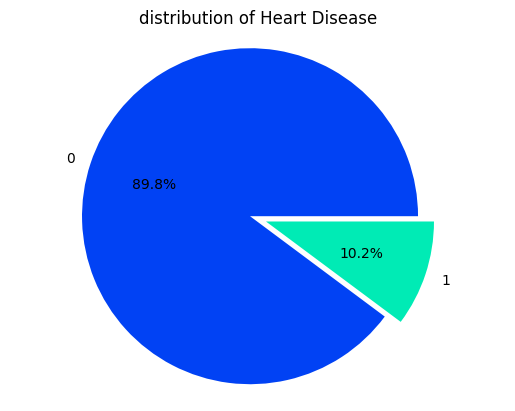

In [83]:
plt.pie(heart_disease_column, labels = heart_disease_column.index, autopct="%1.1f%%", explode = [0,0.1], colors = ["#0142F4","#00EBB5"])
plt.title("distribution of Heart Disease")
plt.axis("equal")
plt.show()

In [84]:
df.HeartDisease.value_counts()

HeartDisease
0    6830
1     775
Name: count, dtype: int64

In [85]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)

# Use SMOTE and RandomUnderSampler as before
over = SMOTE(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=0.1)

# Apply resampling methods to imputed data
X_train_resampled, y_train_resampled = over.fit_resample(X_train_imputed, y_train)

# Check the class distribution after resampling
print(Counter(y_train_resampled))

Counter({1: 5475, 0: 5475})


In [86]:
print("X_train after resampling :", X_train_resampled.shape)
print("y_train after resampling :", y_train_resampled.shape)

X_train after resampling : (10950, 7700)
y_train after resampling : (10950,)


In [87]:
dummy_classifier = DummyClassifier(strategy = 'most_frequent') 
dummy_classifier.fit(X_train, y_train) 
y_pred = dummy_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.8909


In [88]:
def train(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    

def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Greens',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

In [89]:
rf_classifier = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=10, random_state=42)
)

The model with resampling

Cross Validation Score :  98.62%
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1355
           1       0.37      0.08      0.13       166

    accuracy                           0.88      1521
   macro avg       0.63      0.53      0.53      1521
weighted avg       0.84      0.88      0.85      1521

None


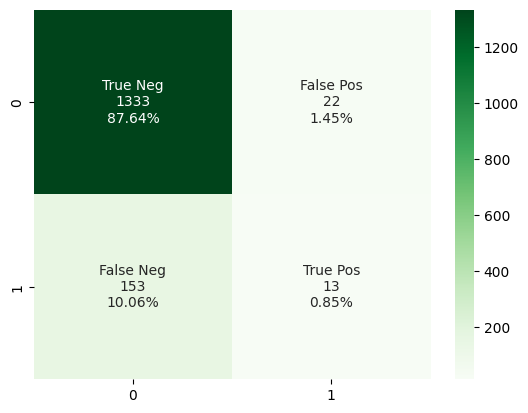

In [90]:
print("The model with resampling\n")
train(rf_classifier, X_train_resampled, y_train_resampled, X_test, y_test)
print(model_evaluation(rf_classifier, X_test, y_test))

The Model withount resampling

Cross Validation Score :  72.08%
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1355
           1       0.20      0.01      0.02       166

    accuracy                           0.89      1521
   macro avg       0.55      0.50      0.48      1521
weighted avg       0.82      0.89      0.84      1521



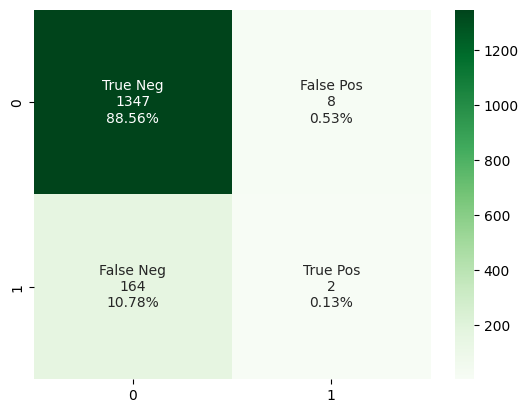

In [91]:
print("The Model withount resampling\n")
train(rf_classifier, X_train, y_train, X_test, y_test)
model_evaluation(rf_classifier, X_test, y_test)